# Predicting Fradulent Credit Card Transactions
 
Data Source: fraud_data.csv | [Kaggle.com](https://www.kaggle.com/isaikumar/creditcardfraud)

This project focuses on training several models and evaluate how effectively they predict instances of fraud using data based on this dataset from Kaggle. Each row in fraud_data.csv corresponds to a credit card transaction. Features include confidential variables V1 through V28 as well as Amount which is the amount of the transaction. The target is stored in the class column, where a value of 1 corresponds to an instance of fraud and 0 corresponds to an instance of not fraud. The goal of the project is to compare various ML methods to find the best model and tuning for the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Step 1: Load and visualize dataset

In [2]:
df = pd.read_csv('fraud_data.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.176563,0.323798,0.536927,1.047002,-0.368652,-0.728586,0.084678,-0.069246,-0.266389,0.155315,...,-0.109627,-0.341365,0.057845,0.499180,0.415211,-0.581949,0.015472,0.018065,4.67,0
1,0.681109,-3.934776,-3.801827,-1.147468,-0.735540,-0.501097,1.038865,-0.626979,-2.274423,1.527782,...,0.652202,0.272684,-0.982151,0.165900,0.360251,0.195321,-0.256273,0.056501,912.00,0
2,1.140729,0.453484,0.247010,2.383132,0.343287,0.432804,0.093380,0.173310,-0.808999,0.775436,...,-0.003802,0.058556,-0.121177,-0.304215,0.645893,0.122600,-0.012115,-0.005945,1.00,0
3,-1.107073,-3.298902,-0.184092,-1.795744,2.137564,-1.684992,-2.015606,-0.007181,-0.165760,0.869659,...,0.130648,0.329445,0.927656,-0.049560,-1.892866,-0.575431,0.266573,0.414184,62.10,0
4,-0.314818,0.866839,-0.124577,-0.627638,2.651762,3.428128,0.194637,0.670674,-0.442658,0.133499,...,-0.312774,-0.799494,-0.064488,0.953062,-0.429550,0.158225,0.076943,-0.015051,2.67,0


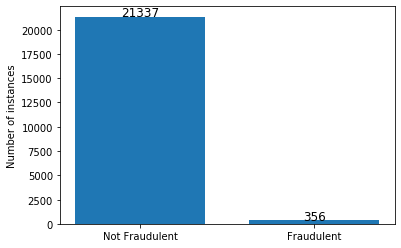

In [3]:
fraud_count = len(df[df['Class'] == 1])
no_fraud_count = len(df[df['Class'] == 0])
x = np.array(['Not Fraudulent', 'Fraudulent'])
y = np.array([no_fraud_count, fraud_count])
bars = plt.bar(x, y, align='center', width = 0.75, color='tab:blue')
plt.ylabel('Number of instances')
for bar in bars:
    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()+ 52, str(int(height)), 
                 ha='center', color='black', fontsize=12)
plt.show()

The data here looks very skewed towards training on many instance of no fraud.  This will be noted as the models are trained and we should expect the models to be better at detecting when fraud does not occur then when fraud does occur (i.e. we can expect when errors occur to be mostly false negatives). False negatives are considered the worst of the two errors as not catching a fraudulent charge is more damaging than breifly freezing an account or investigating into an account that appears to have a fraud charge but does not. This makes using preceision-recall curves more useful than typical area under the curve graphs when we get to tuning the models and the need to prioritize a high recall score as imperative.

### Step 2: Split and prep data

In [4]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1] # class label column
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Step 3: Train and Test Models

#### Model Alpha: Dummy Classifier 

Model simply predicts the most common classifying label in the training set and applies it to the test samples.  In this case, always predicts the case to be not fraudulent.

In [5]:
def dummy_class_model():
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import recall_score, accuracy_score
    dummy_maj = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
    dum_predict = dummy_maj.predict(X_test)
    a = accuracy_score(y_test, dum_predict)
    r = recall_score(y_test, dum_predict)
    return round(a*100,2), r
acc, recall = dummy_class_model()
print('The model has an {}% accuracy and a recall score of {}'.format(acc, recall))

The model has an 98.53% accuracy and a recall score of 0.0


The results show that the while the model appears to highly accurate, the skewedness of the data is causing much noise in the efficacy of the model.  We can assume that fraud in the real world occurs very few times versus non-fraud instances; however, the practicality of this model is lacking and most likely is not the best model in practice since it did not accurately predict when a fraud charge happened.

#### Model Beta: Support Vector Calssifier

Model creates a vector that acts as a boundary between the two classes and is defined by returning a hyperplane that best fits the training data in reducing the error term between each point while ahering to generalization limits (in order not to overfit the data).

In [6]:
def SVC_model():
    from sklearn.metrics import recall_score, precision_score
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC
    svm = SVC().fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    con_m = confusion_matrix(y_test, y_pred)
    print(con_m)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    a = svm.score(X_test, y_test)
    return a, r, p # accuracy, recall score, precision score
SVC_model()

[[5344    0]
 [  50   30]]


(0.9907817109144543, 0.375, 1.0)

This model appears to be a much stronger model than our Dummy Classifier Model.  With an accuracy score of 99.08%, its performace is superiors to the general classifier.  The model appears to have zero false positives (earning a precision score of 1.0) but 50 false negatives (with a recall score of 0.375).  If we assume that false negatives are more dangerous than false positives, then we should strive to limit the amount of false negatives and be willing to trade-off forfeiting a perfect false positive score.

#### Model Gamma: Logistical Regression Classifier
 Model returns a probability that the datapoint is fraudulent or not (which the cutoff is default 0.5). The first step is to build a baseline model and test its accuracy.

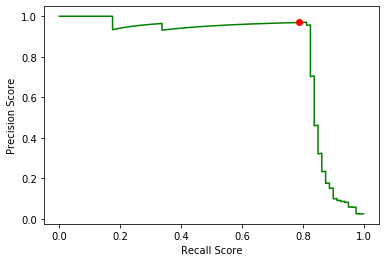

Accuracy Score: 0.9964970501474927
Precision Score: 0.9692307692307692
Recall Score: 0.7875
[[5342    2]
 [  17   63]]


In [7]:
def LRC_model():
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, precision_score, recall_score
    lr = LogisticRegression().fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test)
    y_est = y_pred[:,1]
    y_tested = []
    for point in y_est: # convert probabilities to binary labels
        if point >= 0.5:
            dp = 1
        else:
            dp = 0
        y_tested.append(dp)
    score = accuracy_score(y_test, y_tested)
    matrix = confusion_matrix(y_test, y_tested)
    p_score= precision_score(y_test, y_tested)
    r_score = recall_score(y_test, y_tested)
    precision, recall, thresholds = precision_recall_curve(y_test, y_est) # build precision recall curve
    plt.plot(recall, precision, color='g')
    plt.ylabel('Precision Score')
    plt.xlabel('Recall Score')
    plt.plot(r_score, p_score, color='r', marker='o') # Where on the graph this model variation sits
    plt.show()
    return score, p_score, r_score, matrix
score, p_score, r_score, matrix = LRC_model()
print('Accuracy Score: {}'.format(score))
print('Precision Score: {}'.format(p_score))
print('Recall Score: {}'.format(r_score))
print(matrix)


The baseline model appears to have a fairly high accuracy rate, with only two points being categorized as false positve when the threshold is 0.5.  By looking at the graph, we can see there is a specific point in which we can maximize the area under the curve and both scores can be greater than 0.8 (or at least achieve a greater recall score). Moreover, in comparison to the SVM, we have achieved a higher accuracy rate and a lower false negative rate, thus considering it an even stronger candidate.

#### Model Delta: Logistic Regression using Grid Search

This model utilizes Grid Search to tune hyperparameters to best optimize towards a more accurate model.  Because we want to primarily limit false negatives, the scoring paramter will be set to optimize on the recall metric.  In addition, a penalty will be used and its strength (denoted by C) to help prevent overfitting with 3 cross-fold validation.  Our goal is to find the proper parameters to create the best model optimize on the best recall score that does not forefit much precision or accuracy.

The function returns a table of mean recall test scores as acted on by each corresponding penalty and C value.



In [8]:
def GS_LR_model():    
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression()
    grid_values = {'penalty': ['l1', 'l2'], 'C':[0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(lr, param_grid=grid_values, scoring='recall',cv=3).fit(X_train, y_train)
    grid.decision_function(X_test)
    results = grid.cv_results_
    scores = results['mean_test_score']
    s = scores.reshape(5,2)
    df = pd.DataFrame(s)
    df['C'] = np.array([0.01, 0.1, 1, 10, 100])
    df.set_index('C', inplace=True)
    df.rename(columns={0:'l1',1:'l2'},inplace=True)
    return df
GS_LR_model()

,l1,l2
C,,
0.01,0.666667,0.760870
0.10,0.800725,0.804348
1.00,0.811594,0.811594
10.00,0.807971,0.811594
100.00,0.807971,0.807971


The Grid Search returned mean test scores across each combination of tuning parameters and found that a C of 1 in both l1 and l2 variations returned the highest average test score (along with l2 whe C=10). This score finds the parameters that best tune our logistic regression to limiting false negatives.

#### Model Epsilon: Tuned Logistic Regression

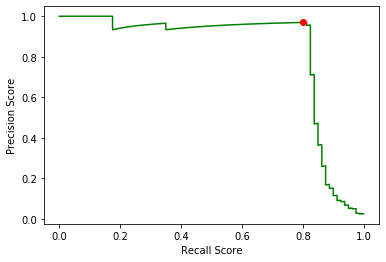

Accuracy Score: 0.9966814159292036
Precision Score: 0.9696969696969697
Recall Score: 0.8
[[5342    2]
 [  16   64]]


In [9]:
def tuned_LR():
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, precision_score, recall_score
    lr = LogisticRegression().fit(X_train, y_train)
    lr = LogisticRegression(penalty='l2', C=10).fit(X_train, y_train) # used l2 as it had more highest mean scores than l1
    y_pred = lr.predict_proba(X_test)
    y_est = y_pred[:,1]
    y_tested = []
    for point in y_est: # converts to binary class labels
        if point >= 0.5:
            dp = 1
        else:
            dp = 0
        y_tested.append(dp)
    score = accuracy_score(y_test, y_tested)
    matrix = confusion_matrix(y_test, y_tested)
    p_score= precision_score(y_test, y_tested)
    r_score = recall_score(y_test, y_tested)
    precision, recall, thresholds = precision_recall_curve(y_test, y_est) # build precision recall curve
    plt.plot(recall, precision, color='g')
    plt.ylabel('Precision Score')
    plt.xlabel('Recall Score')
    plt.plot(r_score, p_score, color='r', marker='o') # Where on the graph this model variation sits
    plt.show()
    return score, p_score, r_score, matrix
Score, P_score, R_score, Matrix = tuned_LR()
print('Accuracy Score: {}'.format(Score))
print('Precision Score: {}'.format(P_score))
print('Recall Score: {}'.format(R_score))
print(Matrix)


Conclusion:

The tuning found a slightly better version of the model than the original regression, improving our false negative score by one case. Meanwhile, our precision score and accuracy Score also imporved marginally.  Thus, we can conclude that this tuned logistic regression is best sutied for the data provided and predicting cases of credit card fraud.  

### Step 4: Build out visualization of Final Model

Written out formula representing our best model in the project

In [10]:
def equation_builder():
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression().fit(X_train, y_train)
    lr = LogisticRegression(penalty='l2', C=10).fit(X_train, y_train)
    combo = zip(df.columns[:-1], lr.coef_[0]) # remove last classification label column from df
    e = 'P(fraud) = '
    for feature in combo:
        f = str(round(feature[1],3)) + feature[0]
        e += f + ' + '
    e = e[:-3]
    print(e)
equation_builder()

P(fraud) = 0.146V1 + -0.015V2 + -0.03V3 + 0.776V4 + 0.124V5 + -0.206V6 + -0.122V7 + -0.295V8 + -0.156V9 + -0.527V10 + 0.376V11 + -0.363V12 + -0.259V13 + -0.823V14 + -0.255V15 + -0.229V16 + -0.019V17 + -0.201V18 + 0.011V19 + -0.246V20 + 0.272V21 + 0.532V22 + -0.072V23 + 0.215V24 + 0.092V25 + -0.54V26 + -0.375V27 + -0.069V28 + 0.001Amount
